<a href="https://colab.research.google.com/github/dlsyscourse/public_notebooks/blob/main/24_machine_learning_compilation_deployment_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 24: Machine Learning Compiler and Deployment

In this lecture, we will walk you through some example usage of the machine learning compiler Apache TVM. To learn more, checkout https://tvm.apache.org/

The content of this lecture is adapted from TVM's tutorials.



## Install package

To get started, we need to obtain a version of TVM. For quick demo purpose we will use the following command to install a packaged version from thirdpary provider 

In [1]:
!python3 -m  pip install tlcpack-nightly -f https://tlcpack.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://tlcpack.ai/wheels
     |████████████████████████████████| 47.5 MB 124 kB/s 


## Loop-level representation and transformations

Let us start with a vector add example. the follow code snippet allows us to create a vector add code, and store it in a container called IRModule.

In [2]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

In [3]:
from tvm import te

A = te.placeholder(shape=(128,), dtype="float32", name="A")
B = te.placeholder(shape=(128,), dtype="float32", name="B")
C = te.compute((128,), lambda i: A[i] + B[i], name="C")
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})

An IRModule contains a collection of low-level functions, we can use the script function to inspect the functions inside an IRModule.  

In [4]:
ir_module.show()

/usr/local/lib/python3.8/dist-packages/tvm/script/highlight.py:116: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/usr/bin/python3 -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


### Build and run

We can turn the programs in an IRModule to runnable functions by calling a build function.

In [ ]:
rt_mod = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
print(type(rt_mod))

<class 'tvm.driver.build_module.OperatorModule'>


After build, mod contains a collection of runnable functions. We can retrieve each function by its name.

In [ ]:
func = rt_mod["main"]

In [ ]:
func

In [ ]:
a = tvm.nd.array(np.arange(128, dtype="float32"))

In [ ]:
b = tvm.nd.array(np.ones(128, dtype="float32")) 

In [ ]:
c = tvm.nd.empty((128,), dtype="float32") 

In [ ]:
 c

<tvm.nd.NDArray shape=(128,), cpu(0)>
array([1.6238352e-36, 0.0000000e+00, 1.4012985e-45, 2.8025969e-45,
       1.4012985e-45, 4.2038954e-45, 4.2038954e-45, 2.8025969e-45,
       4.2038954e-45, 5.6051939e-45, 5.6051939e-45, 2.8025969e-45,
       5.6051939e-45, 2.8025969e-45, 2.8025969e-45, 7.0064923e-45,
       4.2038954e-45, 4.2038954e-45, 4.2038954e-45, 8.4077908e-45,
       8.4077908e-45, 4.2038954e-45, 8.4077908e-45, 9.8090893e-45,
       9.8090893e-45, 4.2038954e-45, 4.2038954e-45, 1.1210388e-44,
       9.8090893e-45, 4.2038954e-45, 5.6051939e-45, 4.2038954e-45,
       1.5414283e-44, 1.6815582e-44, 1.5414283e-44, 1.8216880e-44,
       1.8216880e-44, 1.9618179e-44, 1.8216880e-44, 2.1019477e-44,
       2.1019477e-44, 2.1019477e-44, 2.1019477e-44, 2.2420775e-44,
       2.1019477e-44, 2.3822074e-44, 2.2420775e-44, 2.5223372e-44,
       2.2420775e-44, 2.6624671e-44, 2.6624671e-44, 2.8025969e-44,
       2.6624671e-44, 2.9427268e-44, 2.9427268e-44, 3.0828566e-44,
       2.9427268e-44, 3.

To invoke the function, we can create three NDArrays in the tvm runtime, and then invoke the generated function.

In [ ]:
func(a, b, c)


In [ ]:
print(a)
print(b)
print(c)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

### Transform the code

The IRModule is the central data structure for program optimization, which can be transformed by a helper class called Schedule. A schedule contains multiple primitive methods to interactively transform the program. Each primitive transforms the program in certain ways to bring additional performance optimizations.

Let us try to transform the module, we can do it by creating a Schedule instance.


In [ ]:
sch = tvm.tir.Schedule(ir_module)
print(type(sch))

<class 'tvm.tir.schedule.schedule.Schedule'>


In [ ]:
ir_module.show()

In [ ]:
sch = tvm.tir.Schedule(ir_module)
block_C = sch.get_block("C")
i, = sch.get_loops(block_C)
i0, i1 = sch.split(i, [None, 8])
sch.reorder(i1, i0)
sch.parallel(i1)
sch.mod.show()

Let us first try to split the loops

In [ ]:
# Get block by its name
block_c = sch.get_block("C")
# Get loops surronding the block
(i,) = sch.get_loops(block_c)
# Tile the loop nesting.
i_0, i_1, i_2 = sch.split(i, factors=[None, 4, 4])
sch.mod.show()

We can also reorder the loops, swapping the order of i_0 and i_1



In [ ]:
sch.reorder(i_1, i_0, i_2)
sch.mod.show()

Finally, we can add hints to the program generator that we want to vectorize the inner most loop.

In [ ]:
sch.vectorize(i_2)
sch.mod.show()

## Transforming a matrix multiplication program

In the above example, we showed how to transform an vector add. Now let us try to apply that to a slightly more complicated program(matrix multiplication).


In [ ]:
M = 1024
K = 1024
N = 1024

# The default tensor type in tvm
dtype = "float32"

target = "llvm"
dev = tvm.device(target, 0)

# Algorithm
k = te.reduce_axis((0, K), "k")
A = te.placeholder((M, K), name="A")
B = te.placeholder((K, N), name="B")
C = te.compute((M, N), lambda m, n: te.sum(A[m, k] * B[k, n], axis=k), name="C")

# Default schedule
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})
ir_module.show()

In [ ]:
func = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
a_np = np.random.rand(M, K).astype(dtype)
b_np = np.random.rand(K, N).astype(dtype)
a = tvm.nd.array(a_np, dev)
b = tvm.nd.array(b_np, dev)
c = tvm.nd.array(np.zeros((M, N), dtype=dtype), dev)
func(a, b, c)

evaluator = func.time_evaluator("main", dev, number=3)
print("Baseline time cost %g sec" % evaluator(a, b, c).mean)

Baseline time cost 3.71531


In [ ]:
ir_module.show()

We can transform the loop access pattern to make it more cache friendly. Let us use the following schedule.

In [ ]:
def transform(ir_module, tile_y, tile_x):
    sch = tvm.tir.Schedule(ir_module)
    block_c = sch.get_block("C")
    # Get loops surronding the block
    (y, x, k) = sch.get_loops(block_c)
    yo, yi = sch.split(y, [None, tile_y])
    xo, xi = sch.split(x, [None, tile_x])
    sch.reorder(yo, xo, k, yi, xi)
    return sch.mod


mod = transform(ir_module, 32, 32)
func = tvm.build(mod, target="llvm")  # The module for CPU backends.

evaluator = func.time_evaluator(func.entry_name, dev, number=1)
print("after transformation: %f" % evaluator(a, b, c).mean)

after transformation: 0.373934


after transformation: 0.370416


Try to change the value of bn to see what performance you can get. In pratice, we will leverage an automated system to search over a set of possible transfromations to find an optimal one.



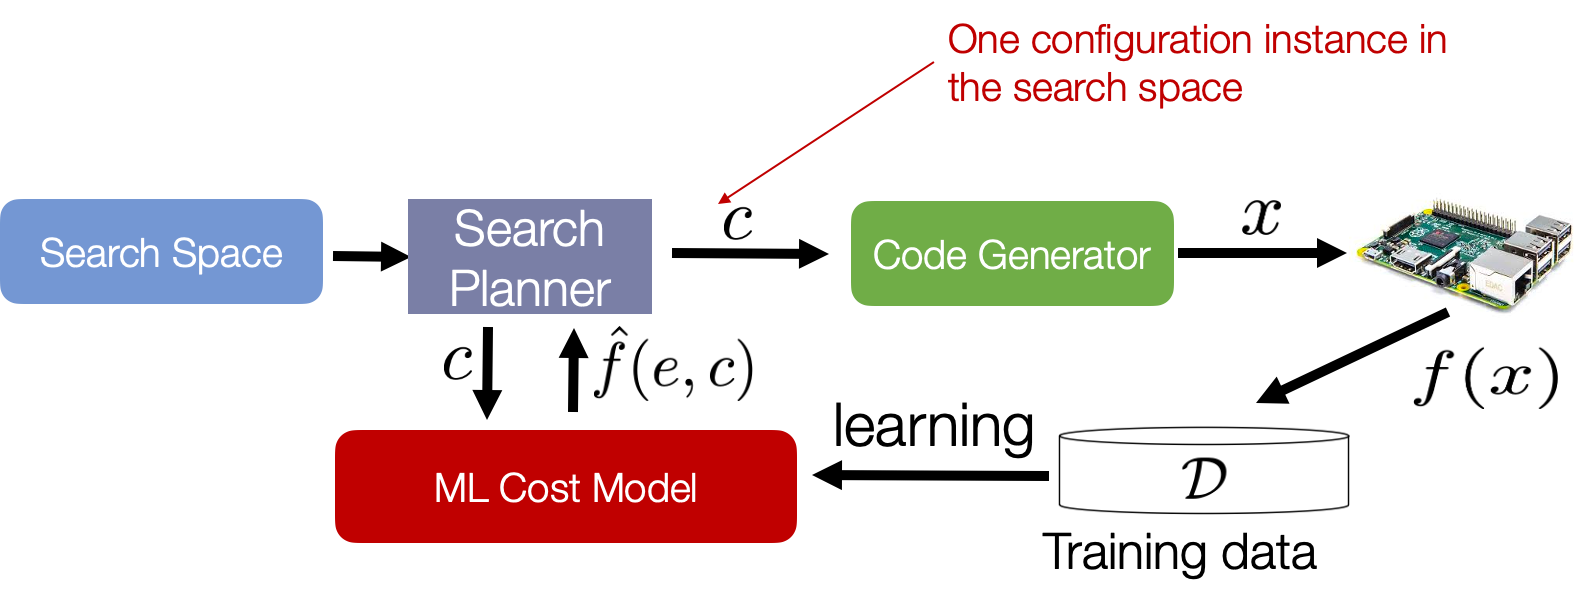

There are other optimizations that can be applied here, such as vectorization, parallelization and data layout optimization. Please checkout

## End to end model deployment

Finally, let us walk through an example flow for an end to end model deployment.



In [ ]:
import tvm
from tvm import relay

import numpy as np

from tvm.contrib.download import download_testdata

# PyTorch imports
import torch
import torchvision

In [ ]:
model_name = "resnet18"
model = getattr(torchvision.models, model_name)(pretrained=True)
model = model.eval()

# We grab the TorchScripted model via tracing
input_shape = [1, 3, 224, 224]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(model, input_data).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

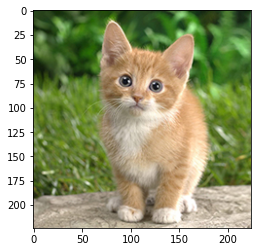

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt


img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
plt.imshow(img)
plt.show()


# Preprocess the image and convert to tensor
from torchvision import transforms

my_preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
img = my_preprocess(img)
img = np.expand_dims(img, 0)

In [ ]:
input_name = "input0"
shape_list = [(input_name, img.shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

In [ ]:
mod

#[version = "0.0.5"]
type List[A] {
  Cons(A, List[A]),
  Nil,
}

type Option[A] {
  Some(A),
  None,
}

type Tree[A] {
  Rose(A, List[Tree[A]]),
}

type tensor_float16_t {
  tensor_nil_float16,
  tensor0_float16(float16),
  tensor1_float16(Tensor[(?), float16]),
  tensor2_float16(Tensor[(?, ?), float16]),
  tensor3_float16(Tensor[(?, ?, ?), float16]),
  tensor4_float16(Tensor[(?, ?, ?, ?), float16]),
  tensor5_float16(Tensor[(?, ?, ?, ?, ?), float16]),
  tensor6_float16(Tensor[(?, ?, ?, ?, ?, ?), float16]),
}

type tensor_float32_t {
  tensor_nil_float32,
  tensor0_float32(float32),
  tensor1_float32(Tensor[(?), float32]),
  tensor2_float32(Tensor[(?, ?), float32]),
  tensor3_float32(Tensor[(?, ?, ?), float32]),
  tensor4_float32(Tensor[(?, ?, ?, ?), float32]),
  tensor5_float32(Tensor[(?, ?, ?, ?, ?), float32]),
  tensor6_float32(Tensor[(?, ?, ?, ?, ?, ?), float32]),
}

type tensor_float64_t {
  tensor_nil_float64,
  tensor0_float64(float64),
  tensor1_float64(Tensor[(?), float64]),


In [ ]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

In [ ]:
from tvm.contrib import graph_executor

dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# Set inputs
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# Execute
m.run()
# Get outputs
tvm_output = m.get_output(0)

In [ ]:
synset_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_synsets.txt",
    ]
)
synset_name = "imagenet_synsets.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(" ") for line in synsets]
key_to_classname = {spl[0]: " ".join(spl[1:]) for spl in splits}

class_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_classes.txt",
    ]
)
class_name = "imagenet_classes.txt"
class_path = download_testdata(class_url, class_name, module="data")
with open(class_path) as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

# Get top-1 result for TVM
top1_tvm = np.argmax(tvm_output.numpy()[0])
tvm_class_key = class_id_to_key[top1_tvm]


print("top-1 id: {}, class name: {}".format(top1_tvm, key_to_classname[tvm_class_key]))


top-1 id: 281, class name: tabby, tabby cat
